In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

In [2]:
rolling_ratings = pd.read_csv('/home/group3/group3/Finalized/data/rolling_period_ratings_stats.csv')
rolling_ratings['reviewDateTime'] = pd.to_datetime(rolling_ratings['reviewDateTime'])

In [3]:
filters = pd.read_pickle('/home/group3/group3/Finalized/groupings/filters.pkl')
by_employee = pd.read_csv('/home/group3/group3/Finalized/groupings/by_employee.csv')
by_industry = pd.read_csv('/home/group3/group3/Finalized/groupings/by_industry.csv')
by_revenue = pd.read_csv('/home/group3/group3/Finalized/groupings/by_revenue.csv')

In [4]:
rolling_ratings = pd.merge(rolling_ratings, by_industry, on='ticker')

# Group by ratings - every month we rank them into 5 bins

In [6]:
filtered_df = rolling_ratings[(rolling_ratings['reviewDateTime']>'2014-01-01') & (rolling_ratings['reviewDateTime']<'2019-9-01')]
universe = list(set(filters['more_than_5_reviews']) & set(filters['on_glassdoor_before_2013']) & set(filters['mcap>e9']))
filtered_df = filtered_df[filtered_df['ticker'].isin(universe)]

In [6]:
def binning_ret(filtered_df):

    lookback_periods = filtered_df.filter(like='_mean').columns
    forward_looking_periods = filtered_df.filter(like='_ret').columns

    for lookback_period in lookback_periods:
        for forward_looking_period in forward_looking_periods:
            print(lookback_period, forward_looking_period)
            group_by_ratings = filtered_df.groupby('reviewDateTime').apply(lambda x: pd.cut(x[lookback_period], bins=5, labels=False))
            filtered_df['group'] = group_by_ratings.values
            returns_by_ratings = filtered_df[['reviewDateTime','group', forward_looking_period]].groupby(['reviewDateTime','group']).apply(lambda x: (x-1).mean())
            ret_by_ratings = returns_by_ratings.unstack()[forward_looking_period].mean()
            plt.bar(x=ret_by_ratings.index, height=ret_by_ratings.values)
            plt.show()


In [4]:
filtered_df = rolling_ratings[(rolling_ratings['reviewDateTime']>'2014-01-01')] # & (rolling_ratings['reviewDateTime']<'2019-9-01')
universe = list(set(filters['more_than_50_reviews']) & set(filters['on_glassdoor_before_2013']) & set(filters['mcap>e9']))
filtered_df = filtered_df[filtered_df['ticker'].isin(universe)]

def ratings_distribution(filtered_df):
    cols = filtered_df.filter(like='_mean').filter(like='1_').columns
    features = [i[2:] for i in cols]
    tr = [1,3,6,9,12]

    # Create a figure with subplots
    fig, ax = plt.subplots(nrows=len(tr), ncols=len(features), figsize=(30, len(features) * 3))

    # Loop through features and thresholds
    for c, f in enumerate(features):
        for r, t in enumerate(tr):
            # Plotting on the specific axes
            sns.histplot(filtered_df[f'{t}_{f}'], bins=50, ax=ax[r][c])
            # ax[r][c].set_title(f'{t}_{f}')  # Optionally set titles for each subplot
            ax[r][c].set_xlabel(f'{t}_{f}')          # Optionally set x-label
            ax[r][c].set_ylabel('Frequency')          # Optionally set y-label

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()



In [56]:
filtered_df = rolling_ratings[(rolling_ratings['reviewDateTime']>'2014-01-01')] # & (rolling_ratings['reviewDateTime']<'2019-9-01')
universe = list(set(filters['more_than_50_reviews']) & set(filters['on_glassdoor_before_2013']) & set(filters['mcap>e9']))
filtered_df = filtered_df[filtered_df['ticker'].isin(universe)]

def conditional_dist(filtered_df, blp=12):

    cols = filtered_df.filter(like='_mean').filter(like='1_').columns
    ret = [1,3,6,9,12,18,24]
    features = [i[2:-5] for i in cols]

    # Create a figure with subplots
    fig, ax = plt.subplots(nrows=len(ret), ncols=len(features), figsize=(30, len(features) * 3))

    for c, f in enumerate(features):
        for r, p in enumerate(ret):
            
            g4_SL = filtered_df[(filtered_df[f'{blp}_{f}_mean']>4) & (filtered_df[f'{blp}_{f}_count']>10)]
            l3_SL = filtered_df[(filtered_df[f'{blp}_{f}_mean']<2) & (filtered_df[f'{blp}_{f}_count']>10)]

            sns.histplot(g4_SL[g4_SL[f'{p}M_ret']<5][f'{p}M_ret']-1, stat='density', bins=30, kde=True,alpha=0.5, label='high ratings', ax=ax[r][c])
            sns.histplot(l3_SL[l3_SL[f'{p}M_ret']<5][f'{p}M_ret']-1, stat='density',bins=30, kde=True,alpha=0.5, label='low ratings', ax=ax[r][c])
            ax[r][c].set_ylabel(f)
    

### pre covid vs covid

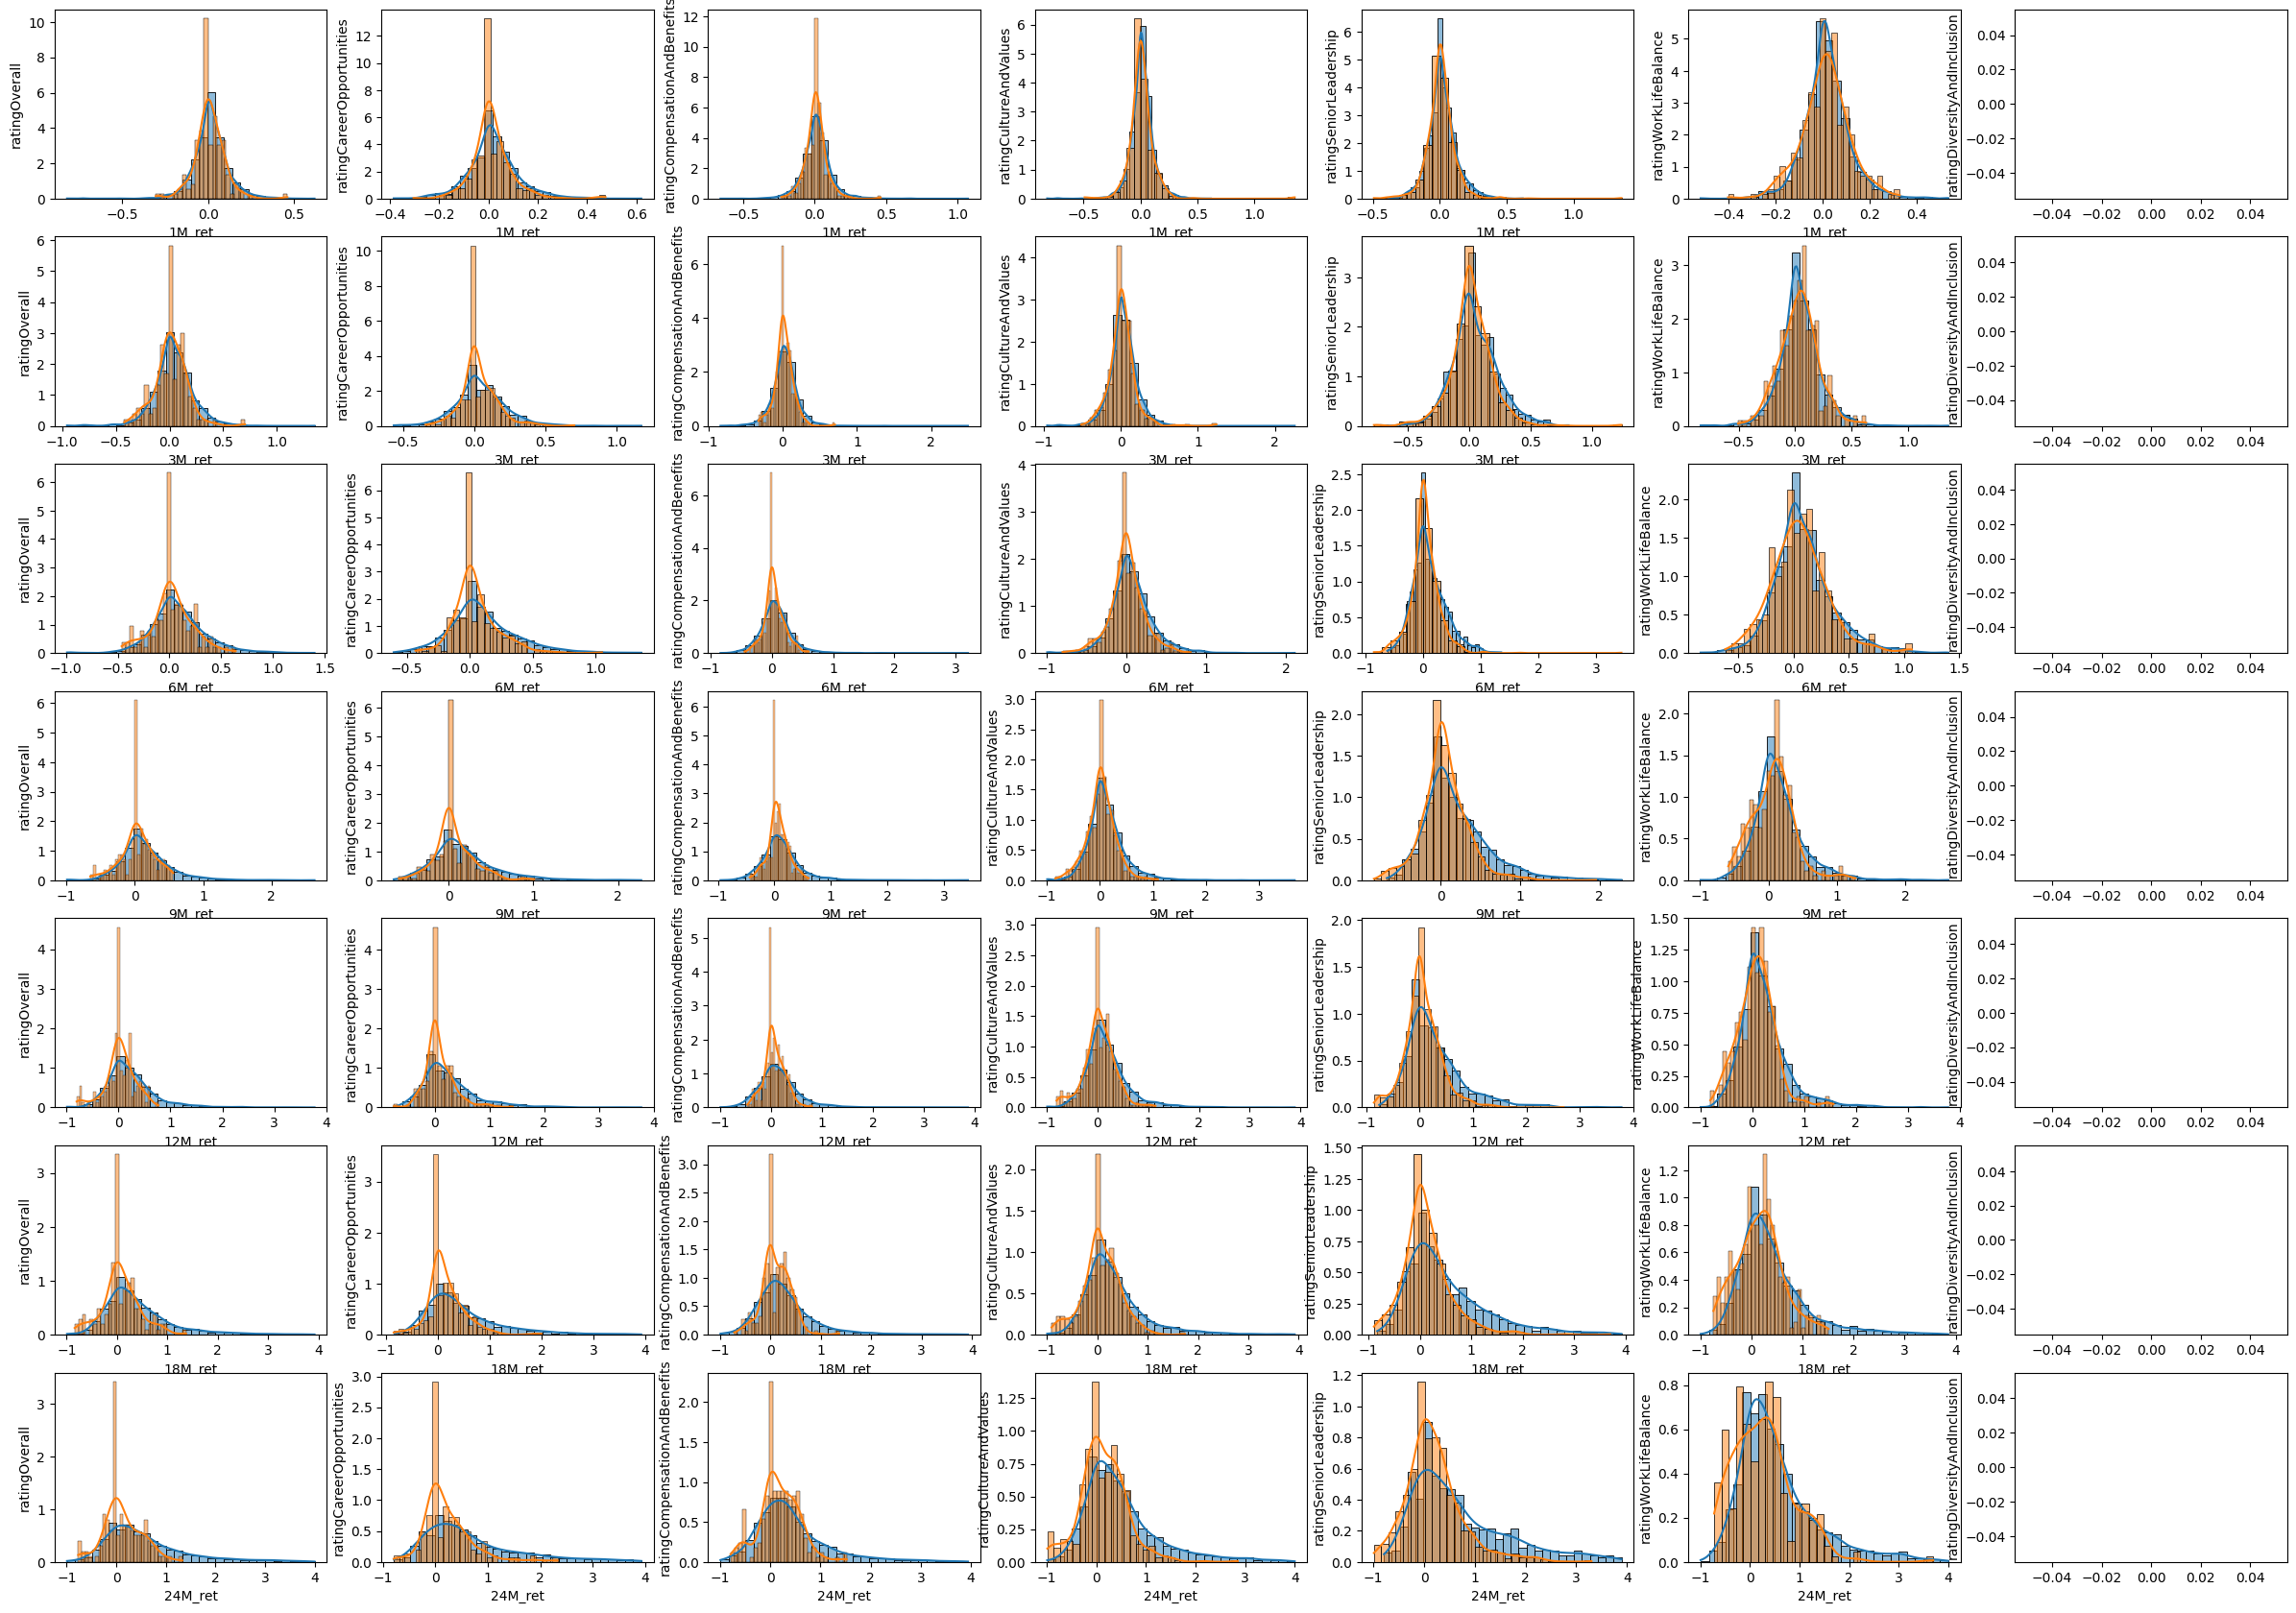

In [57]:
# pre covid
filtered_df = rolling_ratings[(rolling_ratings['reviewDateTime']>'2014-01-01') & (rolling_ratings['reviewDateTime']<'2020-01-01')] 
universe = list(set(filters['more_than_50_reviews']) & set(filters['on_glassdoor_before_2013']) & set(filters['mcap>e9']))
filtered_df = filtered_df[filtered_df['ticker'].isin(universe)]
filtered_df = filtered_df.drop_duplicates()

conditional_dist(filtered_df)

In [ ]:
# covid
filtered_df = rolling_ratings[(rolling_ratings['reviewDateTime']>'2020-01-01') & (rolling_ratings['reviewDateTime']<'2022-01-01')] 
universe = list(set(filters['more_than_50_reviews']) & set(filters['on_glassdoor_before_2013']) & set(filters['mcap>e9']))
filtered_df = filtered_df[filtered_df['ticker'].isin(universe)]

conditional_dist(filtered_df)

### Try do split by employee count

In [62]:
by_employee['group'].value_counts()

group
1001 to 5000 Employees     1084
10000+ Employees            753
51 to 200 Employees         669
201 to 500 Employees        571
501 to 1000 Employees       454
5001 to 10000 Employees     399
1 to 50 Employees           391
Unknown                     146
Name: count, dtype: int64

In [ ]:
large_corp = by_employee[by_employee['group'].isin(['5001 to 10000 Employees', '10000+ Employees'])]['ticker']
filtered_df = rolling_ratings[(rolling_ratings['reviewDateTime']>'2014-01-01') & (rolling_ratings['reviewDateTime']<'2020-01-01')] 
universe = list(set(filters['more_than_50_reviews']) & set(filters['on_glassdoor_before_2013']) & set(filters['mcap>e9']))
filtered_df = filtered_df[filtered_df['ticker'].isin(universe)]
filtered_df = filtered_df[filtered_df['ticker'].isin(large_corp)]

conditional_dist(filtered_df)

In [ ]:
corp_size = by_employee[by_employee['group'].isin(['1 to 50 Employees', '51 to 200 Employees', '201 to 500 Employees', '501 to 1000 Employees', '1001 to 5000 Employees'])]['ticker']
filtered_df = rolling_ratings[(rolling_ratings['reviewDateTime']>'2014-01-01') & (rolling_ratings['reviewDateTime']<'2020-01-01')] 
universe = list(set(filters['more_than_50_reviews']) & set(filters['on_glassdoor_before_2013']) & set(filters['mcap>e9']))
filtered_df = filtered_df[filtered_df['ticker'].isin(universe)]
filtered_df = filtered_df[filtered_df['ticker'].isin(corp_size)]

conditional_dist(filtered_df)

### Deeper Analysis to Ratings with OLS filtered df

In [5]:
employed_df = pd.read_csv('/home/group3/group3/Finalized/data/OLS_dfs/employed_OLS.csv')
helpful_df = pd.read_csv('/home/group3/group3/Finalized/data/OLS_dfs/helpful_OLS.csv')
not_employed_df = pd.read_csv('/home/group3/group3/Finalized/data/OLS_dfs/not_employed_OLS.csv')

In [6]:
ceo_approved_df = pd.read_csv('/home/group3/group3/Finalized/data/OLS_dfs/ceo_approval.csv')
ceo_disapproved_df = pd.read_csv('/home/group3/group3/Finalized/data/OLS_dfs/ceo_disapproval.csv')
merge_ceo_df = pd.merge(ceo_approved_df, ceo_disapproved_df, on=['ticker','reviewDateTime'])
merge_ceo_df['diff'] = merge_ceo_df['12_ratingOverall_count_x'] - merge_ceo_df['12_ratingOverall_count_y']

In [7]:
# filtered_df = rolling_ratings[(rolling_ratings['reviewDateTime']>'2014-01-01') & (rolling_ratings['reviewDateTime']<'2020-01-01')] 
# universe = list(set(filters['more_than_50_reviews']) & set(filters['on_glassdoor_before_2013']) & set(filters['mcap>e9']))
# filtered_df = filtered_df[filtered_df['ticker'].isin(universe)]
# top10_industry = by_industry.groupby('group').count().sort_values(by='ticker', ascending=False)[:10].index
# filtered_df = pd.merge(filtered_df, by_industry, on='ticker')
# for group in top10_industry:
#     industry_filtered = filtered_df[filtered_df['group']==group]
#     print(group, end='\n\n\n')
#     conditional_dist(industry_filtered)

In [23]:
def conditional_dist_twodf(filtered_df, filtered_df2, blp=12, hl='high ratings', ll='low ratings'):
    ret = [1, 3, 6, 9, 12, 18, 24]
    ncols = 2

    # Create subplots
    fig, ax = plt.subplots(nrows=(len(ret) // ncols) + (len(ret) % ncols > 0), ncols=ncols, figsize=(30, (len(ret) // ncols + 1) * 3))

    for r, p in enumerate(ret):
        c = r % ncols
        row = r // ncols  # Store row in a separate variable to avoid overwriting

        # Plotting histograms for filtered_df
        sns.histplot(
            filtered_df[filtered_df[f'{p}M_ret'] < 5][f'{p}M_ret'] - 1,
            stat='density', bins=30, kde=True, alpha=0.5, label=hl, ax=ax[row][c]
        )
        
        # Plotting histograms for filtered_df2
        sns.histplot(
            filtered_df2[filtered_df2[f'{p}M_ret'] < 5][f'{p}M_ret'] - 1,
            stat='density', bins=30, kde=True, alpha=0.5, label=ll, ax=ax[row][c]
        )
        
        # Set labels and titles
        ax[row][c].set_xlabel(f'{p}M_ret')
        ax[row][c].set_title(f'Distribution for {p}M_ret')
        ax[row][c].legend()

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

<Axes: xlabel='diff', ylabel='Count'>

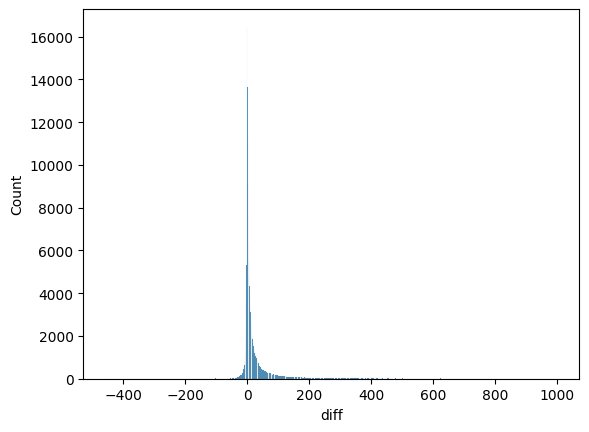

In [34]:
sns.histplot(merge_ceo_df[merge_ceo_df['diff']<1000]['diff'])

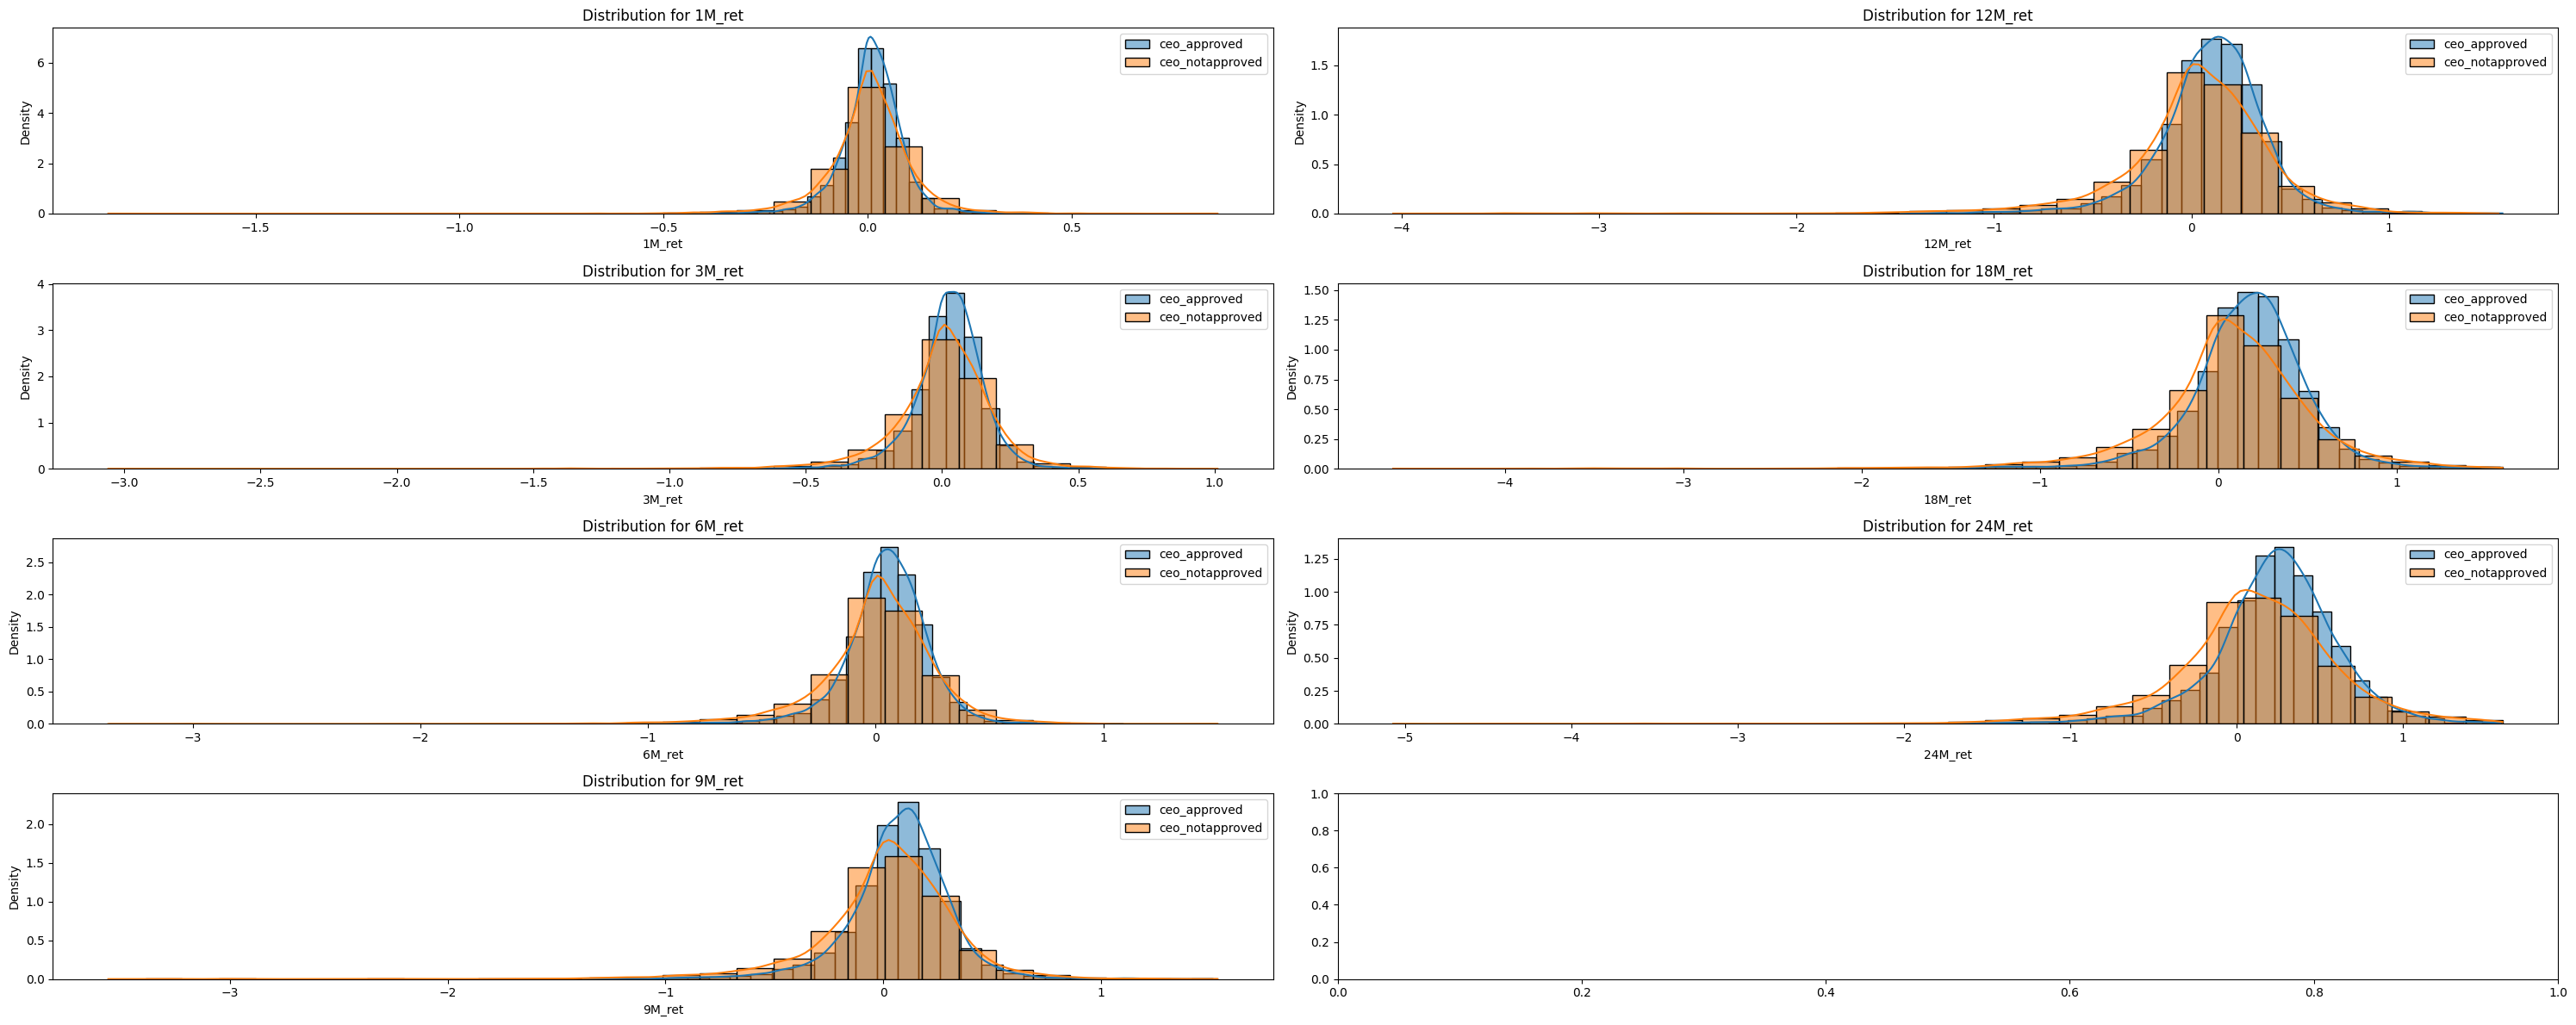

In [9]:
filtered_df = merge_ceo_df[(merge_ceo_df['reviewDateTime']>'2014-01-01')] 
universe = list(set(filters['more_than_50_reviews']) & set(filters['on_glassdoor_before_2013']) & set(filters['mcap>e9']))
filtered_df = filtered_df[filtered_df['ticker'].isin(universe)]

ret = [1, 12, 3, 18, 6, 24, 9]
ncols = 2

# Create subplots
fig, ax = plt.subplots(nrows=(len(ret) // ncols) + (len(ret) % ncols > 0), ncols=ncols, figsize=(30, (len(ret) // ncols + 1) * 3))

for r, p in enumerate(ret):
    c = r % ncols
    row = r // ncols  # Store row in a separate variable to avoid overwriting

    approved = filtered_df[filtered_df['diff']>100]
    notapproved = filtered_df[filtered_df['diff']<0]
    # Plotting histograms for filtered_df
    sns.histplot(
        np.log(approved[approved[f'{p}M_ret_x'] < 5][f'{p}M_ret_x']),
        stat='density', bins=30, kde=True, alpha=0.5, label='ceo_approved', ax=ax[row][c]
    )
    
    # Plotting histograms for filtered_df2
    sns.histplot(
        np.log(notapproved[notapproved[f'{p}M_ret_x'] < 5][f'{p}M_ret_x']),
        stat='density', bins=30, kde=True, alpha=0.5, label='ceo_notapproved', ax=ax[row][c]
    )
    
    # Set labels and titles
    ax[row][c].set_xlabel(f'{p}M_ret')
    ax[row][c].set_title(f'Distribution for {p}M_ret')
    ax[row][c].legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [34]:
filtered_df = rolling_ratings[(rolling_ratings['reviewDateTime']>'2014-01-01') & (rolling_ratings['reviewDateTime']<'2020-01-01')] 
universe = list(set(filters['more_than_50_reviews']) & set(filters['on_glassdoor_before_2013']) & set(filters['mcap>e9']))
filtered_df = filtered_df[filtered_df['ticker'].isin(universe)]

In [44]:
biotech = filtered_df[filtered_df['group']=='Biotech & Pharmaceuticals']

<Axes: xlabel='12_ratingSeniorLeadership_mean', ylabel='Count'>

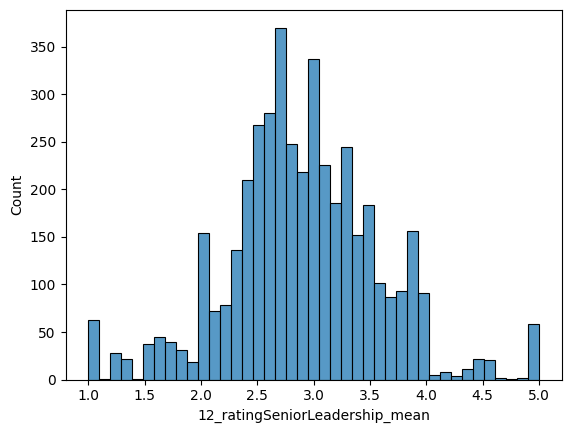

In [45]:
sns.histplot(biotech['12_ratingSeniorLeadership_mean'])